In [1]:
import tensorflow as tf
import pandas as pd
import os

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

data_csv = tf.keras.utils.get_file(fname=os.path.basename(dataset_url),
                                           origin=dataset_url)

df=pd.read_csv(data_csv,skiprows=1,header=None)

8192/2194 [================================================================================================================] - 0s 0us/step


In [2]:
#podzial na wej i wyj
X=df.iloc[:,0:4].values
Y=df.iloc[:,4:5].values

In [3]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import numpy as np

y = np.ravel(Y)

In [39]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
  model = Sequential()
  model.add(Dense(32, input_shape=(4,)))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(3, activation = 'softmax'))

  model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam', metrics='accuracy' )

  return model

In [6]:
from sklearn.model_selection import train_test_split
# Keep a 10% holdout
x_main, x_holdout, y_main, y_holdout = train_test_split(    
    X, Y, test_size=0.10) 

In [11]:
y_main = np.ravel(y_main)
# Encode classes as integers
encoder = LabelEncoder()
encoder.fit(y_main)
encoded_Y = encoder.transform(y_main)

# One hot encode integer labels
one_hot_Y = np_utils.to_categorical(encoded_Y)

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

n_split=3
oos_y = []
oos_pred = []

for train_index,test_index in StratifiedKFold(n_split).split(x_main,y_main):
  x_train,x_test=x_main[train_index],x_main[test_index]
  y_train,y_test=one_hot_Y[train_index],one_hot_Y[test_index]
  
  model=create_model()
  history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=25, verbose=0)

  pred = model.predict(x_test)

  y_test = np.argmax(y_test,axis=1)
  oos_y.append(y_test)
  #print(oos_y)

  # raw probabilities to chosen class (highest probability)
  pred = np.argmax(pred,axis=1) 
  oos_pred.append(pred) 
  #print(oos_pred)

   # Measure this fold's accuracy
  #y_compare = np.argmax(y_test,axis=1) # For accuracy calculation
  score = metrics.accuracy_score(y_test, pred)
  print(f"Fold score (accuracy): {score}")


  y_test=to_categorical(y_test) 
  print('Model evaluation ',model.evaluate(x_test,y_test))

Fold score (accuracy): 0.8611111111111112
2/2 [==============================] - 0s 3ms/step - loss: 0.5183 - accuracy: 0.8611
Model evaluation  [0.518275260925293, 0.8611111044883728]
Fold score (accuracy): 0.7222222222222222
2/2 [==============================] - 0s 4ms/step - loss: 0.5129 - accuracy: 0.7222
Model evaluation  [0.5129252672195435, 0.7222222089767456]
Fold score (accuracy): 0.9444444444444444
2/2 [==============================] - 0s 4ms/step - loss: 0.4922 - accuracy: 0.9444
Model evaluation  [0.49219396710395813, 0.9444444179534912]


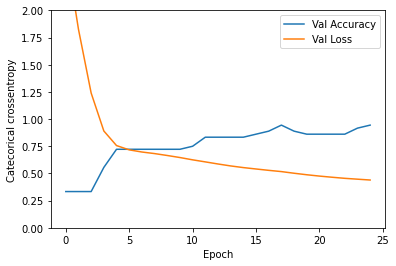

In [46]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Catecorical crossentropy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Loss')
    plt.legend()
    plt.ylim([0,2])

plot_history()

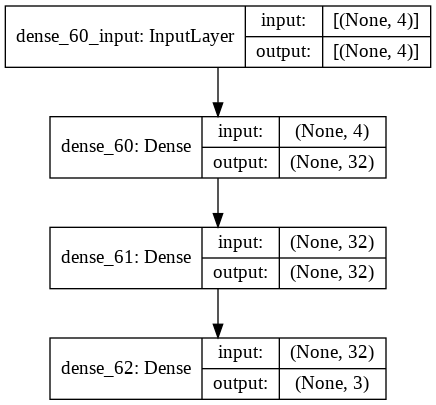

In [48]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [49]:
# Write the cross-validated prediction (from the last neural network)
holdout_pred = model.predict(x_holdout)

In [55]:
print(holdout_pred)
holdout_pred = np.argmax(holdout_pred,axis=1)
print(holdout_pred)

[2 1 1 0 0 0 0 1 2 2 0 0]


In [57]:
print(y_holdout)

[1 1 1 0 0 0 0 1 1 2 0 0]


In [58]:
score = metrics.accuracy_score(y_holdout, holdout_pred)
print(f"Final score (accuracy): {score}")    
    
# Write the cross-validated prediction
oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)
oosDF = pd.concat( [df, oos_y, oos_pred],axis=1 )

Final score (accuracy): 0.8333333333333334
